### Fig. 11

In [ ]:

import numpy as np
import pandas as pd
import sys, os
# sys.path.append('../src/')
sys.path.append('/home/caoyuyao/dataset_14T/UID-Moji/src') # --qg
from utils import get_hour_list, load_pressure_data, truncate_colormap, LandUse, \
    TcTools, if_in_china_index
from tqdm import tqdm
from datetime import datetime, timedelta
from quality_control import QualityControlTool
from interpolation import idw_interpolate_fastknn, idw_interpolate
import netCDF4 as nc
import matplotlib.pyplot as plt
from visualization import ObservationMap, ProbabilityMatrix
from scipy.io import netcdf
from interpolation import idw_interpolate_fastknn
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.gridspec as gridspec
import matplotlib
import seaborn as sns
from matplotlib import font_manager 
font_path = "/mnt/cyy14/data_qg/old_draw/font"
font_files = font_manager.findSystemFonts(fontpaths=font_path)
for file in font_files:
    font_manager.fontManager.addfont(file)
plt.rcParams["font.sans-serif"] = "Arial"


def plot_radar_Lekima(lst_hour_name, figure_type = 'contourf', obs_map = None, cmap = None, zorder = 4, alpha = 0.4):
    utc_hour = (datetime.strptime(lst_hour_name, '%Y%m%d%H') - timedelta(hours = 8)).strftime('%Y%m%d%H')
    # radar_dir = '/media/cyy2/CMA_RADA/'
    radar_dir = '/mnt/cyy2/CMA_RADA/' # --qg
    file_name = 'Z_RADR_I_CHINA_{:s}0000_O_DOR_MOC_CAP_FMT.nc'.format(utc_hour)
    ds = nc.Dataset(radar_dir + file_name, mode = 'r')
    variables = list(ds.variables)

    crf = ds['observation.prdt_crf_raw_log'][0, :, :]
    print('Data loaded!')
    lat_list = np.linspace(14.1, 51.8, 4188)
    lon_list = np.linspace(74.2, 134.7, 5640)

    new_crf = crf.copy()
    new_crf[new_crf<25] = np.NaN
    lon_grid, lat_grid = np.meshgrid(lon_list, lat_list)

    lon_tick=np.arange(119.8, 121.3, 0.5)
    lat_tick=np.arange(30.7, 32.2, 0.5)
    
    if obs_map is None:
        obs_map = ObservationMap(llon = 117.2, rlon = 123.2, llat = 27.3, ulat = 33.3)
        obs_map.set_map(province = True, coastline = False, south_China_sea =False, grid=True, \
                    label_left=1, label_down=1, tick_label_size=12, lon_ticks=lon_tick, lat_ticks=lat_tick, projection='lcc',\
                    lat_0=31.2, lat_1=31.7, lon_0=120.3, width=6.1E5/5, height=6.8E5/5, lock_aspect=True)

    
    if figure_type == 'contourf':
        if cmap is None:
            cs = obs_map.contourf(lon_grid, lat_grid, new_crf, levels = np.linspace(25, 50, 6), cmap = 'jet', zorder = zorder, alpha = alpha,\
                                 latlon=True)
        else:
            cs = obs_map.contourf(lon_grid, lat_grid, new_crf, levels = np.linspace(25, 50, 6), cmap = cmap, zorder = zorder, alpha = alpha,\
                                 latlon=True)
    else:
        if cmap is None:
            pass
        else:
            cmap = truncate_colormap('binary', 0.65, 0.7)
        cs = obs_map.contour(lon_grid, lat_grid, new_crf, levels = [35], cmap = cmap, zorder = zorder, latlon=True)

    return cs

def plot_radar_INFA(lst_hour_name, figure_type = 'contourf', obs_map = None, cmap = None, zorder = 4, alpha = 0.4):
    utc_hour = (datetime.strptime(lst_hour_name, '%Y%m%d%H') - timedelta(hours = 8)).strftime('%Y%m%d%H')
    # radar_dir = '/media/cyy2/CMA_RADA/'
    radar_dir = '/mnt/cyy2/CMA_RADA/' # --qg
    file_name = 'Z_RADR_I_CHINA_{:s}0000_O_DOR_MOC_CAP_FMT.nc'.format(utc_hour)
    ds = nc.Dataset(radar_dir + file_name, mode = 'r')
    variables = list(ds.variables)

    crf = ds['observation.prdt_crf_raw_log'][0, :, :]
    lat_list = np.linspace(23.2, 39.6, crf.shape[0])
    lon_list = np.linspace(113.2, 124.5, crf.shape[1])

    new_crf = crf.copy()
    new_crf[new_crf<25] = np.NaN
    lon_grid, lat_grid = np.meshgrid(lon_list, lat_list)
    
    lon_tick=np.arange(119.2, 120.7, 0.5)
    lat_tick=np.arange(30.8, 32.3, 0.5)
    
    if obs_map is None:
        obs_map = ObservationMap(llon = 117.2, rlon = 123.2, llat = 27.3, ulat = 33.3)
        obs_map.set_map(province = True, coastline = False, south_China_sea =False, grid=True, \
                    label_left=0, label_down=1, tick_label_size=12, lon_ticks=lon_tick, lat_ticks=lat_tick, projection='lcc',\
                    lat_0=31.2, lat_1=31.7, lon_0=120.3, width=6.1E5/5, height=6.8E5/5, lock_aspect=True)
    
    if figure_type == 'contourf':
        if cmap is None:
            cs = obs_map.contourf(lon_grid, lat_grid, new_crf, levels = np.linspace(25, 50, 6), cmap = 'jet', zorder = zorder, alpha = alpha,\
                                 latlon=True)
        else:
            cs = obs_map.contourf(lon_grid, lat_grid, new_crf, levels = np.linspace(25, 50, 6), cmap = cmap, zorder = zorder, alpha = alpha,\
                                 latlon=True)
    else:
        if cmap is None:
            pass
        else:
            cmap = truncate_colormap('binary', 0.65, 0.7)
        cs = obs_map.contour(lon_grid, lat_grid, new_crf, levels = [35], cmap = cmap, zorder = zorder, latlon=True)

    return cs
        
    
def get_tc_location(tc_year, tc_name, hour_name):   

    data_dir = '/mnt/cyy14/TC_information/'
    tc_info_dict = np.load(data_dir+'STI-tc_info_dict_2016-2021.npy', allow_pickle = 'True').item()
    tc_info_list = tc_info_dict[(tc_year, tc_name.upper())]

    for i in range(len(tc_info_list)):
        tmp_hour_name = tc_info_list[i][0]
        tmp_lon = tc_info_list[i][1]
        tmp_lat = tc_info_list[i][2]
        tmp_pressure = tc_info_list[i][3]

        d1 = int((tmp_lat - 0)/0.5)
        d2 = int((tmp_lon - 70)/0.5)
        if d1<0 or d1>=110 or d2<0 or d2>=140 or if_in_china_index[d1, d2]==0:
            continue

        if tmp_hour_name == hour_name:
            return tmp_lon, tmp_lat, tmp_pressure  


def load_hourly_sphn_data(tc_name = 'HAGUPIT', hour_name = '2019080405'):

    if tc_name.upper() == 'HAGUPIT':
        data_dir = '/mnt/cyy14/2020080400-2020080523_119.0-123.0_27.0-35.0_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'
    elif tc_name.upper() == 'IN-FA':
        data_dir = '/mnt/cyy14/2021072500-2021073023_115.0-125.0_29.0-40.0_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'
    elif tc_name.upper() == 'LEKIMA':
        data_dir = '/mnt/cyy14/2019080910-2019081110_117.2-123.2_27.3-33.3_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'
    # --qg
    
    try:
        data = np.load(data_dir + hour_name + '_QCed_smartphone_data.npy')
        return data
    except FileNotFoundError:
        print('Wrong file name!')
        

def get_landmask(coord = 'c'):

    data_path = '/mnt/cyy14/WRF_Lake/met_em.d01.2021-06-30_06:00:00.nc' 
    ds = nc.Dataset(data_path)

    lon_c = ds.variables['XLONG_C'][0, :, :]
    lat_c = ds.variables['XLAT_C'][0, :, :]

    lon_m = ds.variables['XLONG_M'][0, :, :]
    lat_m = ds.variables['XLAT_M'][0, :, :]
    landmask = ds.variables['LANDMASK'][0, :, :]

    '''XLONG_C: corner?'''
    '''XLONG_M: Middle?'''
    ds.close()

    if coord.upper() == 'C':
        return lon_c, lat_c, landmask
    else:
        return lon_m, lat_m, landmask    


def add_landmask(obs_map, fill_type = 'contourf'):
    lon_c, lat_c, landmask = get_landmask()
    lon_m, lat_m, landmask = get_landmask('M')
    
    cmap = truncate_colormap(cmap = 'Blues_r', minval = 0.8, maxval = 1, n = 100)
    if fill_type == 'pcolormesh':
        obs_map.pcolormesh(lon_c, lat_c, landmask, cmap = cmap, colorbar = False, zorder = 1)
    else:
        obs_map.contourf(lon_m, lat_m, landmask, levels = [0, 1], cmap = cmap, colorbar = False, zorder=1)    
    print(lon_m.shape)
    print(lat_m.shape)
    print(landmask.shape)


def get_tc_pressure_list(source = 'STI', tc_year = 2021, tc_name = 'IN-FA'):
    if tc_name.upper() == 'HAGUPIT':
        hour_list = ['2020080420', '2020080423', '2020080502']
    else:
        hour_list = get_hour_list('2021072605', '2021072923')[::3]


    data_dir = '/mnt/cyy14/TC_information/'
    tc_info_dict = np.load(data_dir+source+'-tc_info_dict_2016-2021.npy', allow_pickle = 'True').item()
    tc_info_list = tc_info_dict[(tc_year, tc_name.upper())]

    tc_pressure_list = []
    for i in range(len(tc_info_list)):
        hour_name = str(tc_info_list[i][0])
        tc_pressure = tc_info_list[i][3]
        if hour_name not in hour_list:
            continue
        tc_pressure_list.append(tc_pressure)
        
    return tc_pressure_list


def get_cover_ratio_list(hour_list = None, resolution = 0.05, box_size = 0.3, tc_name = 'IN-FA'):
    if hour_list is None:
        hour_list = get_hour_list('2021072605', '2021072923')[::3]   
    
    cover_ratio_list = []
    cover_ratio_dict = {}
    for hour_name in hour_list:
        data = load_hourly_sphn_data(tc_name, hour_name)
        
        tc_lon, tc_lat, _ = get_tc_location(2021, tc_name, hour_name)

        start_lon = tc_lon - box_size
        start_lat = tc_lat - box_size

        cover_grid = np.zeros((int(box_size*2/resolution), int(box_size*2/resolution)))
        for i in range(data.shape[0]):
            lon = data[i, 0]
            lat = data[i, 1]

            d1 = int((lat - start_lat)/resolution)
            d2 = int((lon - start_lon)/resolution)

            if d1<0 or d1>=cover_grid.shape[0] or d2<0 or d2>=cover_grid.shape[1]:
                continue  
            cover_grid[d1, d2] = 1
        
        cover_ratio = np.sum(cover_grid)/cover_grid.size
        cover_ratio_list.append(cover_ratio)

        cover_ratio_dict[hour_name] = cover_ratio

    return cover_ratio_list, cover_ratio_dict            


def interquartile_check(data, radius = 0.5, no_screen=False):
    '''
    data: 3 columns, lon, lat, pressure
    '''
    start_lat = int(np.nanmin(data[:, 1])*10)/10
    start_lon = int(np.nanmin(data[:, 0])*10)/10

    grid_sphn_dict = {}
    resolution = radius
    thld = 1
    for i in range(data.shape[0]):
        lon = data[i, 0]
        lat = data[i, 1]
        pressure = data[i, 2]

        d1 = int((lat - start_lat)/resolution)
        d2 = int((lon - start_lon)/resolution)
        grid_sphn_dict.setdefault((d1, d2), []).append([lon, lat, pressure])   

    stacked_data = np.zeros((0, 3))
    for key in grid_sphn_dict:
        grid_sphn_dict[key] = np.array(grid_sphn_dict[key])
        perc_25 = np.nanpercentile(grid_sphn_dict[key][:, 2], 25)
        perc_75 = np.nanpercentile(grid_sphn_dict[key][:, 2], 75)
        inter_range = perc_75 - perc_25
        valid_ind = (grid_sphn_dict[key][:, 2] - perc_75<=thld*inter_range) & \
            (perc_25 - grid_sphn_dict[key][:, 2]<=thld*inter_range)
        
        valid_data = grid_sphn_dict[key][valid_ind|no_screen]
        stacked_data = np.vstack((stacked_data, valid_data))
    return stacked_data


In [ ]:

import matplotlib.pyplot as plt
import matplotlib as mpl
red_color=[]
for i in range(11):
    red_color.append(((250-3*i)/255, (220-15*i)/255, (220-15*i)/255))

blue_color=[(30, 132, 73), (34, 153, 84), (39, 174, 96), (82, 190, 128), (169, 223, 191), (213, 216, 220)]
new_blue=[]
for i in blue_color:
    new_blue.append((i[0]/255, i[1]/255, i[2]/255))
color_list=new_blue+red_color

cmap = (mpl.colors.ListedColormap(color_list[1:-1])
        .with_extremes(under=color_list[0], over=color_list[-1])) 


  
# under 和 over 用于显示 norm 范围之外的数据。
#bounds = np.arange(-2, 3, 1)
bounds = np.arange(-2, 5.5, 0.5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

(320, 482)
(320, 482)
(320, 482)
(320, 482)
(320, 482)
(320, 482)


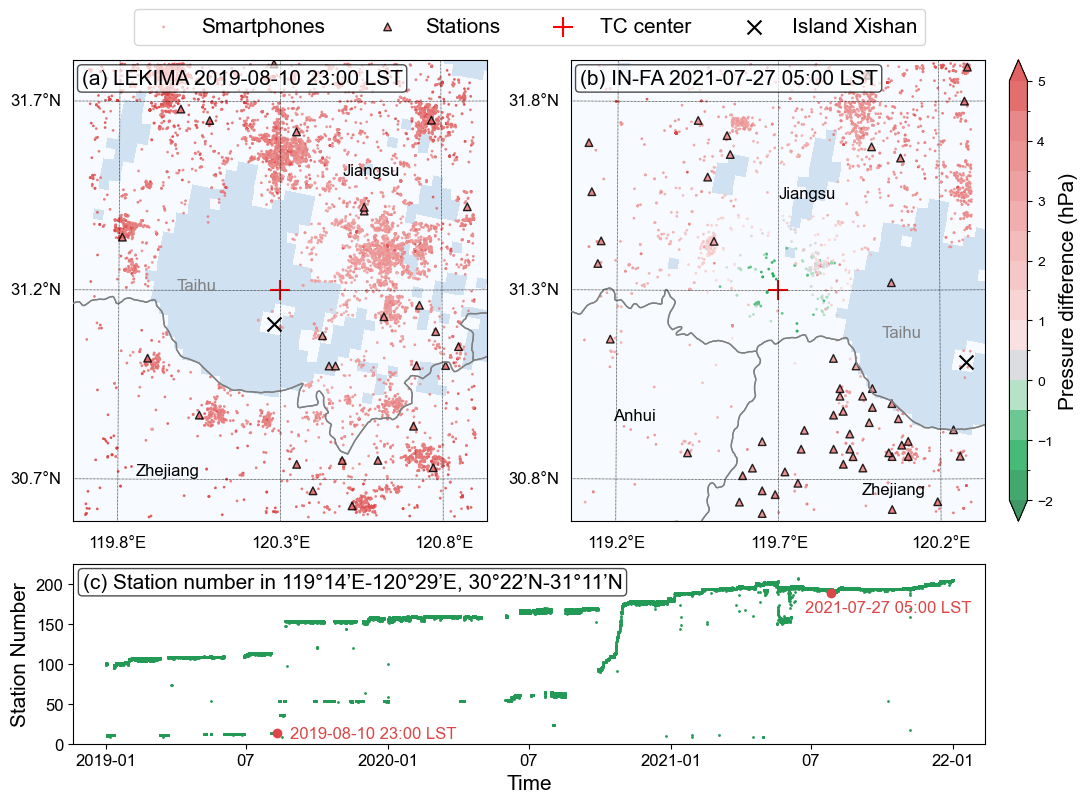

In [ ]:

fig=plt.figure(1)
fig.set_size_inches(12, 12)


mx=0.12
my=0.215
x0=0.345
y0=0.345/6.1*6.8
y1=0.15

hour_name_list=['2019081023', '2021072705']
year_list=[2019, 2021]
typhoon_list=['LEKIMA', 'IN-FA']
axs_list=[[mx, 1-my-y0, x0, y0], [1-mx-x0, 1-my-y0, x0, y0]]
axs1=[mx, my, 1-2*mx, y1]
lat0_list=[31.2, 31.3, ]
lon0_list=[120.3, 119.7, ]

for j in range(2):
    ax=plt.axes(axs_list[j])
    plt.sca(ax)
    radius=0.6
    hour_name=hour_name_list[j]

    tc_lon, tc_lat, tc_pressure = get_tc_location(year_list[j], typhoon_list[j], hour_name)

    hourly_sphn_data = load_hourly_sphn_data(typhoon_list[j], hour_name)
    region_ind = (hourly_sphn_data[:, 0]>=tc_lon-radius) & (hourly_sphn_data[:, 0]<=tc_lon+radius) &\
        (hourly_sphn_data[:, 1]>=tc_lat-radius) & (hourly_sphn_data[:, 1]<=tc_lat+radius)
    hourly_sphn_data = hourly_sphn_data[region_ind]

    sphn_lons = hourly_sphn_data[:, 0]
    sphn_lats = hourly_sphn_data[:, 1]
    sphn_pressure_list = hourly_sphn_data[:, 2]

    station_data = load_pressure_data(hour_name, True)
    region_ind = (station_data[:, 1]>=tc_lon-radius) & (station_data[:, 1]<=tc_lon+radius) & (station_data[:, 2]>=tc_lat-radius) & (station_data[:, 2]<=tc_lat+radius)
    valid_ind = (~np.isnan(station_data[:, 4])) & (station_data[:, 3]<=50)
    station_data = station_data[region_ind & valid_ind, :]

    station_data = interquartile_check(station_data[:, np.array([1, 2, 4])], radius = 0.5) 
    
  
    obs_map = ObservationMap(llon = tc_lon - radius, rlon = tc_lon + radius, llat = tc_lat - radius, ulat = tc_lat + radius)
    lon_ticks = np.linspace(tc_lon - 0.5, tc_lon + 0.5, 3)
    lat_ticks = np.linspace(tc_lat - 0.5, tc_lat + 0.5, 3)
    obs_map.set_map(province = True, coastline = False, south_China_sea =False, grid=True, \
                    label_left=1, label_down=1, tick_label_size=12, lon_ticks=lon_ticks, lat_ticks=lat_ticks, projection='lcc',\
                    lat_0=lat0_list[j], lat_1=lat0_list[j]+0.5, lon_0=lon0_list[j], width=6.1E5/5, height=6.8E5/5, lock_aspect=True,\
                    province_boundary_color = 'gray', zorder=999)

    add_landmask(obs_map, fill_type = 'pcolormesh')

    # 980 - 1000
    num_colors = 20


    lowest_values = np.sort(sphn_pressure_list)[:int(sphn_pressure_list.shape[0]*0.1)]

    cs = obs_map.scatter(sphn_lons, sphn_lats, np.array(sphn_pressure_list)-tc_pressure, cmap = cmap, marker_size = 1, \
      colorbar = False, alpha = 0.85, label = 'Smartphones', norm=norm)
    plt.clim(-5, 5)

    center_ind  = (station_data[:, 1]>=tc_lon-0.4) & (station_data[:, 1]<=tc_lon+0.4) & (station_data[:, 2]>=tc_lat-0.4) & (station_data[:, 2]<=tc_lat+0.4)
    obs_map.scatter(station_data[:, 0], station_data[:, 1], station_data[:, 2]-tc_pressure, marker = '^', marker_size = 30, cmap = cmap,\
    alpha = 0.85, label = 'Stations', edgecolor = 'k', colorbar = False, zorder = 9)
    plt.clim(-5, 5)
    obs_map.scatter([tc_lon], [tc_lat], color = 'red', marker = '+', marker_size = 200, \
                    label = 'TC center')
    obs_map.scatter([120.28], [31.11], facecolor='k', edgecolor='k', marker = 'x', marker_size = 100, color='k',\
                    label = 'Island Xishan')
    
    

    props = dict(boxstyle='round,pad=0.2', fc='white', ec='k',lw=1 ,alpha=0.7)
    textstr = datetime.strptime(hour_name, '%Y%m%d%H').strftime('%Y-%m-%d %H:00 LST')
    ax.text(0.02, 0.98, '({:s}) '.format(chr(j+97))+typhoon_list[j]+' '+textstr, transform=ax.transAxes, fontsize=15,\
            verticalalignment='top', horizontalalignment='left', bbox=props, color = 'k', zorder = 999999)
    
    if j!=1:
        plt.text(0.25, 0.5, s = 'Taihu', fontsize=12, transform=ax.transAxes, color = 'grey', zorder = 999999, fontweight = 'bold')
        plt.text(0.15, 0.1, s = 'Zhejiang', fontsize=12, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
        plt.text(0.65, 0.75, s = 'Jiangsu', fontsize=12, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')

    else:
        plt.text(0.75, 0.4, s = 'Taihu', fontsize=12, transform=ax.transAxes, color = 'grey', zorder = 999999, fontweight = 'bold')
        plt.text(0.7, 0.06, s = 'Zhejiang', fontsize=12, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
        plt.text(0.5, 0.7, s = 'Jiangsu', fontsize=12, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
        plt.text(0.1, 0.22, s = 'Anhui', fontsize=12, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
            


ax.legend(loc = 'lower right', bbox_to_anchor=(0.88,1.01), ncol = 4, fontsize=15)
cbar_ax = fig.add_axes([1-mx+0.02,  1-my-y0, 0.015, y0])
fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='both')
cbar_ax.set_ylabel('Pressure difference (hPa)', fontsize = 15)


ax=plt.axes(axs1)
plt.sca(ax)
hour_list=get_hour_list('2019010100', '2021123123')
num_list=np.load('/mnt/cyy14/data_qg/old_draw/station_num.npy', allow_pickle=True)
a1=np.where(np.array(hour_list)=='2019081023')
a2=np.where(np.array(hour_list)=='2021072705')
xtick_loc=[]
xtick_name=['2019-01', '07', '2020-01', '07', '2021-01', '07', '22-01']
for hour in ['2019010100', '2019070100', '2020010100', '2020070100', '2021010100', '2021070100', '2021123123']:   
    xtick_loc.append(np.where(np.array(hour_list)==hour)[0][0])

text_color=color_list[-1]
scatter_color=color_list[1]
plt.scatter(list(range(len(num_list))), num_list, s=1, c=scatter_color)
plt.scatter([a1[0][0], a2[0][0]],[num_list[a1[0][0]], num_list[a2[0][0]]], c=text_color)
plt.text(a1[0][0]+400, num_list[a1[0][0]], '2019-08-10 23:00 LST', va='center', ha='left', c=text_color, fontsize=12)
plt.text(a2[0][0]-800, num_list[a2[0][0]]-10, '2021-07-27 05:00 LST', va='top', ha='left', c=text_color, fontsize=12)
ax.text(0.01, 0.95, "(c) Station number in 119°14’E-120°29’E, 30°22’N-31°11’N", transform=ax.transAxes, fontsize=15,\
            verticalalignment='top', horizontalalignment='left', bbox=props, color = 'k', zorder = 999999)
plt.ylim(0,225)
plt.xlim(-1000,len(num_list)+1000)
plt.xticks(xtick_loc, xtick_name, fontsize = 12)
plt.yticks(list(range(0,225, 50)), fontsize = 12)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Station Number', fontsize = 15)

fig_dir = '/mnt/cyy14/data_qg/old_draw/submission1/'
plt.savefig(fig_dir + 's3.png', dpi = 300, format='png', bbox_inches = 'tight')

